# Kappa model probability tree

Laurent, J., Yang, J., & Fontana, W. (2018). [Counterfactual resimulation for causal analysis of rule-based models](https://dl.acm.org/doi/abs/10.5555/3304889.3304920)  *Proceedings of the 27th International Joint Conference on Artificial Intelligence*. IJCAI’18.

Models based on rules that express local and heterogeneous mechanisms of stochastic interactions between structured agents are an important tool for investigating the dynamical behavior of complex systems, especially in molecular biology. Given a simulated trace of events, the challenge is to construct a causal diagram that explains how a phenomenon of interest occurred. Counterfactual analysis can provide distinctive insights, but its standard definition is not applicable in rule-based models because they are not readily expressible in terms of structural equations. We provide a semantics of counterfactual statements that addresses this challenge by sampling counterfactual trajectories that are probabilistically as close to the factual trace as a given intervention permits them to be. We then show how counterfactual dependencies give rise to explanations in terms of relations of enablement and prevention between events.

## States

![KappaStates.png](KappaStates.png)

## Rules

![KappaRules.png](KappaRules.png)



In [7]:
from probability_trees import MinCut, PTree, Critical
def KappaModel( bvars, b = 0.0093,
                      u = 0.9337,
                      u_star = 0.0093,
                      pS = 0.0467,
                      pK = 0.001, 
                      tmax=6,
                      semantics='trace'):
    
    t=0
    if 'Rule0' not in bvars:
        return init( t )
    while f'Rule{t}' in bvars:
        t += 1
    if t <= tmax:
        return apply_rules( bvars, t, b, u, u_star, pS , pK, semantics )
    else:
        return None   

def init( t):
    return f'Rule{t}=init, bind{t}=0, S{t}=u, K{t}=u'

def apply_rules( bvar, t, b, u, u_star, pS, pK, semantics='trace' ):
    prob_state = []
    prob_state.append( binding( bvar, b, t ) )
    prob_state.append(fast_unbinding(bvar, u, t ) )
    prob_state.append( slow_unbinding( bvar, u_star, t ) )
    prob_state.append(substrate_phosphorylation( bvar, pS, t))
    prob_state.append( kinase_phosphorylation( bvar, pK, t))
    total_prob = sum([prob for prob, state in prob_state])
    if semantics=='trace':
        return [(prob/total_prob, state) 
                for prob, state in prob_state
                if prob > 0]
    else:
        return [(prob/total_prob, state) 
                for prob, state in prob_state]


def binding( bvar, b, t ):
    bind, S, K = bvar[f'bind{t-1}'], bvar[f'S{t-1}'], bvar[f'K{t-1}']
    if bind == '0':
        return b, f'Rule{t}=b, bind{t}=1, S{t}={S}, K{t}={K}'
    else:
        return 0, f'Rule{t}=b, bind{t}={bind}, S{t}={S}, K{t}={K}'

def fast_unbinding( bvar, u, t):
    bind, S, K = bvar[f'bind{t-1}'], bvar[f'S{t-1}'], bvar[f'K{t-1}']
    if bind == '1' and K == 'u':
        return u, f'Rule{t}=u, bind{t}=0, S{t}={S}, K{t}={K}'
    else:
        return 0, f'Rule{t}=u, bind{t}={bind}, S{t}={S}, K{t}={K}'
    
def slow_unbinding( bvar, u_star, t):
    bind, S, K = bvar[f'bind{t-1}'], bvar[f'S{t-1}'], bvar[f'K{t-1}']
    if bind == '1' and K == 'p':
        return u_star, f'Rule{t}=u_star, bind{t}=0, S{t}={S}, K{t}={K}'
    else:
        return 0, f'Rule{t}=u_star, bind{t}={bind}, S{t}={S}, K{t}={K}'

def substrate_phosphorylation( bvar, pS, t ):
    bind, S, K = bvar[f'bind{t-1}'], bvar[f'S{t-1}'], bvar[f'K{t-1}']
    if bind == '1' and S == 'u':
        return pS, f'Rule{t}=pS, bind{t}={bind}, S{t}=p, K{t}={K}'
    else:
        return 0, f'Rule{t}=pS, bind{t}={bind}, S{t}={S}, K{t}={K}'
    
def kinase_phosphorylation( bvar, pK, t ):
    bind, S, K = bvar[f'bind{t-1}'], bvar[f'S{t-1}'], bvar[f'K{t-1}']
    if K == 'u':
        return pK, f'Rule{t}=pK, bind{t}={bind}, S{t}={S}, K{t}=p'
    else:
        return 0, f'Rule{t}=pK, bind{t}={bind}, S{t}={S}, K{t}={K}'
        
    

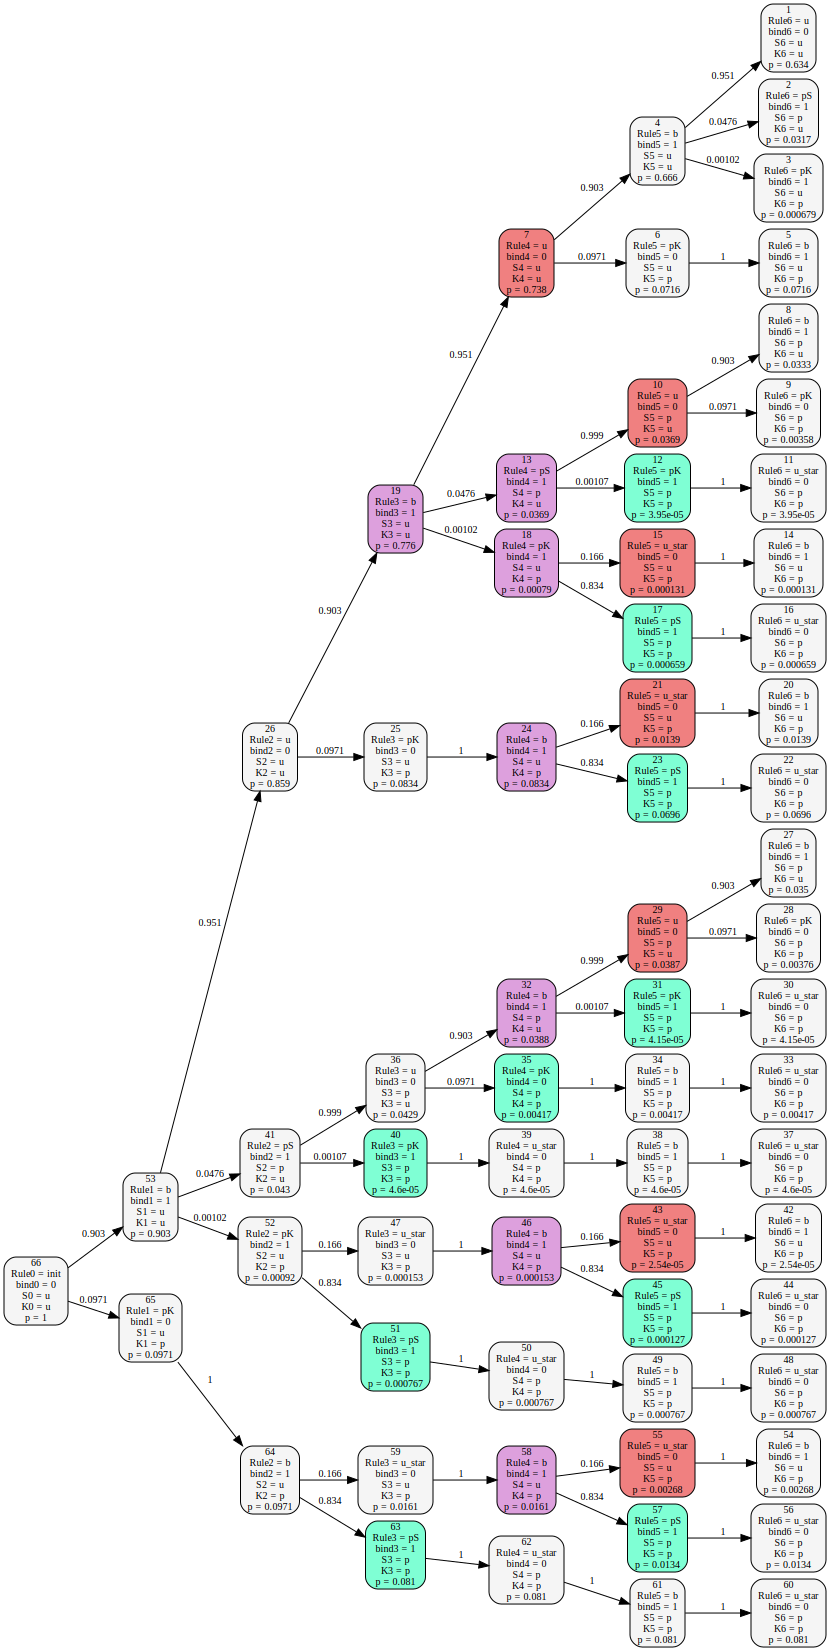

In [9]:
kappa = PTree.fromFunc(KappaModel, init( 0 ))
display(kappa.show(show_prob=True,
            cut=kappa.prop('Rule6=u_star'),
                crit=kappa.critical(kappa.prop('Rule6=u_star')),
                show_id=True
               ))

## Factual trace

![Factual trace](FactualTrace.png)

In [10]:
b1, u2, pK3, b4, p5, u_star6 = (kappa.prop('Rule1=b'), 
                          kappa.prop('Rule2=u'), 
                          kappa.prop('Rule3=pK'),
                          kappa.prop('Rule4=b'),
                          kappa.prop('Rule5=pS'),
                          kappa.prop('Rule6=u_star'))
factual_trace = kappa.see(b1 & u2 & pK3 & b4 & p5 & u_star6)



## Enablement graph




![Enablement graph](EnablementGraph.png)




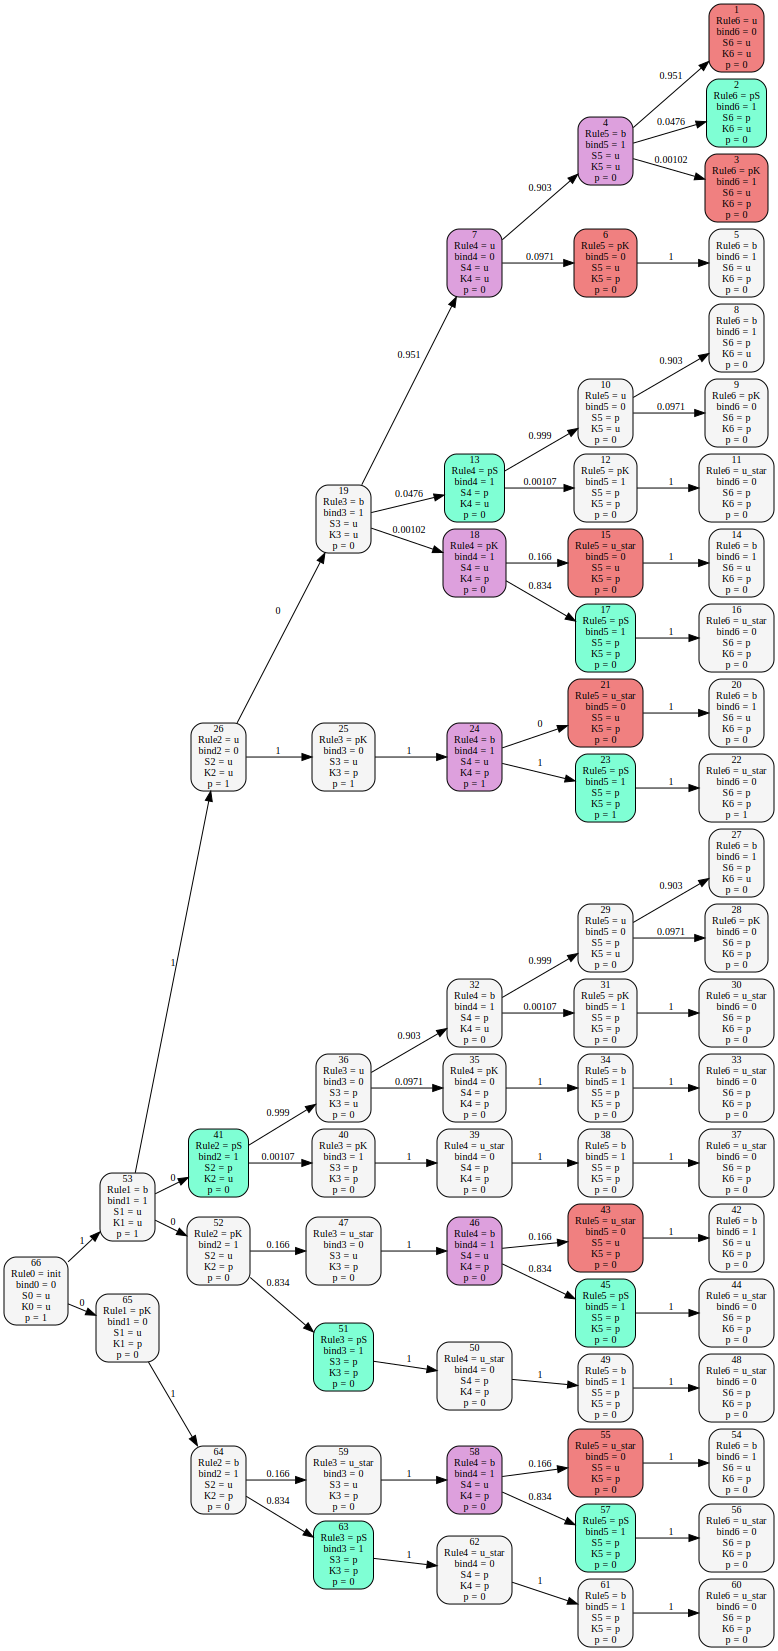

In [11]:

init_enables_b = ((kappa.prop('Rule0=init') < kappa.prop('Rule1=b')) | 
                  (kappa.prop('Rule0=init') < kappa.prop('Rule2=b')) |
                  (kappa.prop('Rule0=init') < kappa.prop('Rule3=b')) |
                  (kappa.prop('Rule0=init') < kappa.prop('Rule4=b')) |
                  (kappa.prop('Rule0=init') < kappa.prop('Rule5=b')) |
                  (kappa.prop('Rule0=init') < kappa.prop('Rule6=b')))

b1_enables_pS = ((kappa.prop('Rule1=b') < kappa.prop('Rule2=pS'))| 
                 (kappa.prop('Rule1=b') < kappa.prop('Rule3=pS')) | 
                 (kappa.prop('Rule1=b') < kappa.prop('Rule4=pS')) | 
                 (kappa.prop('Rule1=b') < kappa.prop('Rule5=pS')) | 
                 (kappa.prop('Rule1=b') < kappa.prop('Rule6=pS')))
b2_enables_pS =  ((kappa.prop('Rule2=b') < kappa.prop('Rule3=pS')) | 
                 (kappa.prop('Rule2=b') < kappa.prop('Rule4=pS')) |
                 (kappa.prop('Rule2=b') < kappa.prop('Rule5=pS')) |
                 (kappa.prop('Rule2=b') < kappa.prop('Rule6=pS'))) 

b3_enables_pS = ((kappa.prop('Rule3=b') < kappa.prop('Rule4=pS')) |
                 (kappa.prop('Rule3=b') < kappa.prop('Rule5=pS')) |
                 (kappa.prop('Rule3=b') < kappa.prop('Rule6=pS')))
b4_enables_pS = ((kappa.prop('Rule4=b') < kappa.prop('Rule5=pS')) |
                 (kappa.prop('Rule4=b') < kappa.prop('Rule6=pS')))

b5_enables_pS = kappa.prop('Rule5=b') < kappa.prop('Rule6=pS')
    
b_enables_pS = b1_enables_pS | b2_enables_pS | b3_enables_pS | b4_enables_pS | b5_enables_pS                
                 
display(factual_trace.show(show_prob=True,
                cut= init_enables_b & b_enables_pS,
                crit=kappa.critical(init_enables_b & b_enables_pS ),
                show_id=True
               ))
                          
                        

## Counterfactual Trace

In [12]:
counterfactual_trace = kappa.cf(factual_trace, ~pK3)

![Prevention graph](PreventionGraph.png)


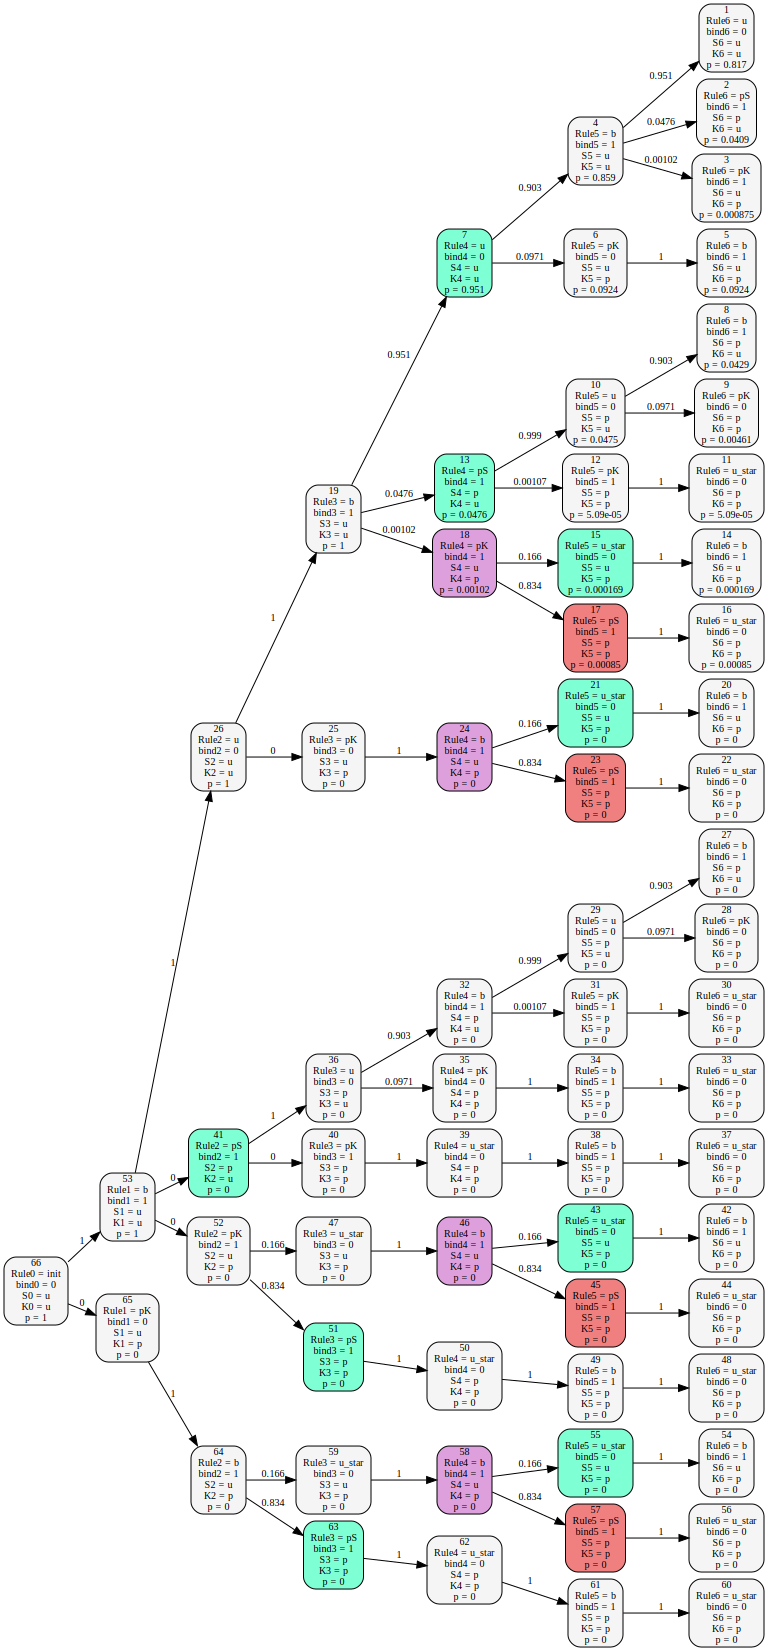

In [13]:
init_enables_pK = ((kappa.prop('Rule0=init') < kappa.prop('Rule1=pK')) | 
                  (kappa.prop('Rule0=init') < kappa.prop('Rule2=pK')) |
                  (kappa.prop('Rule0=init') < kappa.prop('Rule3=pK')) |
                  (kappa.prop('Rule0=init') < kappa.prop('Rule4=pK')) |
                  (kappa.prop('Rule0=init') < kappa.prop('Rule5=pK')) |
                  (kappa.prop('Rule0=init') < kappa.prop('Rule6=pK')))

pK1, pK2, pK3, pK4, pK5 = (kappa.prop('Rule1=pK'), 
                           kappa.prop('Rule2=pK'), 
                           kappa.prop('Rule3=pK'), 
                           kappa.prop('Rule4=pK'),
                           kappa.prop('Rule5=pK'))
u2, u3, u4, u5, u6 = (kappa.prop('Rule2=b'),
                      kappa.prop('Rule3=u'),
                      kappa.prop('Rule4=u'),
                      kappa.prop('Rule5=u'),
                      kappa.prop('Rule6=u')
                     )

p3, p4, p5, p6 = (kappa.prop('Rule3=pS'),
                  kappa.prop('Rule4=pS'),
                  kappa.prop('Rule5=pS'),
                  kappa.prop('Rule6=pS'))

not_pK3_enables_u = (~pK3 < u4) | (~pK3 < u5) | (~pK3 < u6) 
                           
pK3_prevents_u = ~not_pK3_enables_u

not_u2_enables_p = (~u2 < p3) | (~u2 < p4 ) | (~u2 < p5) | (~u2 < p6)
not_u3_enables_p =  (~u3 < p4 ) | (~u3 < p5) | (~u3 < p6)
not_u4_enables_p =  (~u4 < p5) | (~u4 < p6)
not_u5_enables_p = ~u5 < p6

not_u_enables_p = not_u2_enables_p | not_u3_enables_p | not_u4_enables_p | not_u5_enables_p

u_prevents_p = ~not_u_enables_p

u4_prevents_p = ~not_u4_enables_p
display(counterfactual_trace.show(show_prob=True,
                cut=u4_prevents_p,
                crit=kappa.critical(u4_prevents_p),
                show_id=True
               ))

# PTree by hand (doesnt work)

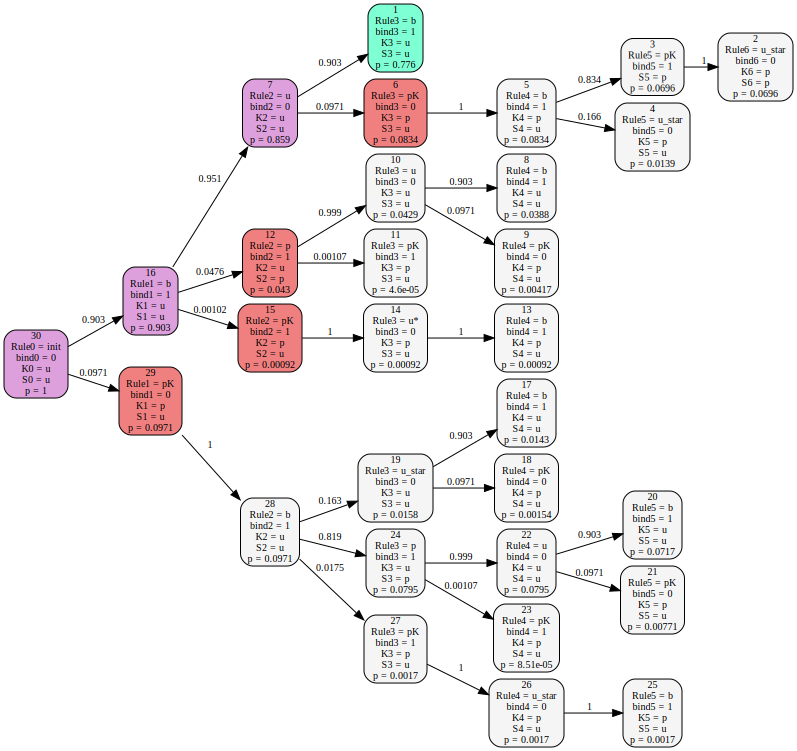

In [41]:
# Creata a blank probability tree.
from probability_trees import MinCut, Critical, PTree

pt = PTree()
b = 0.0093
u = 0.9337
u_star = 0.0093
p = 0.0467
pK = 0.001
# Add a root node and the children.
pt.root('Rule0=init, bind0=0, K0=u, S0=u', [
    pt.child(b/(b+pK), 'Rule1=b, bind1=1, K1=u, S1=u',[
        pt.child(u/(u+p+pK),   'Rule2=u, bind2=0, K2=u ,S2=u',[
            pt.child(b/(b+pK),    'Rule3=b, bind3=1, K3=u ,S3=u'),
            pt.child(pK/(b+pK),   'Rule3=pK, bind3=0, K3=p, S3=u',[
                pt.child(b/b,       'Rule4=b, bind4=1, K4=p, S4=u',[
                    pt.child(p/(p+u_star),      'Rule5=pK, bind5=1, S5=p',[
                        pt.child(u_star/u_star,      'Rule6=u_star, bind6=0, K6=p, S6=p')
                    ]),
                    pt.child(u_star/(p+u_star), 'Rule5=u_star, bind5=0, K5=p, S5=u')
                ])
            ])  
        ]),
        pt.child(p/(u+p+pK),    'Rule2=p, bind2=1, K2=u, S2=p',[
            pt.child(u/(u+pK),     'Rule3=u, bind3=0, K3=u, S3=u',[
                pt.child(b/(b+pK),    'Rule4=b, bind4=1, K4=u, S4=u'),
                pt.child(pK/(b+pK),   'Rule4=pK, bind4=0, K4=p ,S4=u')
            ]),
            pt.child(pK/(u+pK),    'Rule3=pK, bind3=1, K3=p, S3=u')
        ]),
        pt.child(pK/(u+p+pK),   'Rule2=pK, bind2=1, K2=p, S2=u',[
            pt.child(u_star/u_star, 'Rule3=u*, bind3=0, K3=p, S3=u',[
                pt.child(b/b,          'Rule4=b, bind4=1, K4=p, S4=u')
            ]),
        ])
    ]),
    pt.child(pK/(b+pK), 'Rule1=pK, bind1=0, K1=p, S1=u',[
        pt.child(b/b,      'Rule2=b , bind2=1, K2=u, S2=u',[
            pt.child(u_star/(u_star + p + pK), 'Rule3=u_star, bind3=0, K3=u, S3=u',[
                pt.child(b/(b+pK),                'Rule4=b, bind4=1, K4=u, S4=u'),
                pt.child(pK/(b+pK),               'Rule4=pK, bind4=0, K4=p, S4=u')
            ]),
            pt.child(p/(u_star + p + pK),      'Rule3=p, bind3=1, K3=u, S3=p',[
                pt.child(u/(u+pK),               'Rule4=u, bind4=0, K4=u, S4=u',[
                    pt.child(b/(b+pK),               'Rule5=b, bind5=1, K5=u, S5=u'),
                    pt.child(pK/(b+pK),              'Rule5=pK, bind5=0, K5=p, S5=u')
                ]),
                pt.child(pK/(u+pK),              'Rule4=pK, bind4=1, K4=p, S4=u')
            ]),
            pt.child(pK/(u_star + p + pK),     'Rule3=pK , bind3=1, K3=p, S3=u',[
                pt.child(u_star/u_star,            'Rule4=u_star, bind4=0, K4=p, S4=u',[
                    pt.child(b/b,                     'Rule5=b, bind5=1, K5=p, S5=u')
                ]),
            ])
        ])
     ])
])



# Display it.
display(pt.show(show_prob=True,
            cut=pt.prop('Rule3=b'),
                crit=pt.critical(pt.prop('Rule3=b')),
                show_id=True
               ))

In [53]:
init(0)

[(1, 'Rule0=init, bind0=0, S0=u, K0=u')]